In [52]:
import pathlib
import json
import torch
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [3]:
# here we are loading a list of json objects from a file
data_folder=pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\data\recipes")
data_filename = "full_format_recipes.json"
data_file = data_folder/data_filename

with open(str(data_file),"r") as fh:
    recipe_data = json.load(fh)

print(f"recipe_data length : {len(recipe_data)}")

recipe_data length : 20130


In [4]:
# we are building a list of text. each text is recipe title and recipe directions concatenated with a pipe character
recipe_text = [f"Recipe for {recipe['title']} | {' '.join([direction for direction in recipe['directions']])}" 
               for recipe in recipe_data 
               if 'title' in recipe 
               and recipe['title'] is not None 
               and 'directions' in recipe 
               and recipe['directions'] is not None]

In [5]:
print(f"recipe_text length : {len(recipe_text)}")

recipe_text length : 20111


# Build tokenizer

In [6]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

In [8]:
# we initialize tokenizer provided by torchtext.utils.data
# this basic english tokenizer tokenizes english text on whitespaces and punctuation marks
tokenizer = get_tokenizer('basic_english')

tokenized_text = tokenizer(recipe_text[0])
print(tokenized_text)

['recipe', 'for', 'lentil', ',', 'apple', ',', 'and', 'turkey', 'wrap', '|', '1', '.', 'place', 'the', 'stock', ',', 'lentils', ',', 'celery', ',', 'carrot', ',', 'thyme', ',', 'and', 'salt', 'in', 'a', 'medium', 'saucepan', 'and', 'bring', 'to', 'a', 'boil', '.', 'reduce', 'heat', 'to', 'low', 'and', 'simmer', 'until', 'the', 'lentils', 'are', 'tender', ',', 'about', '30', 'minutes', ',', 'depending', 'on', 'the', 'lentils', '.', '(', 'if', 'they', 'begin', 'to', 'dry', 'out', ',', 'add', 'water', 'as', 'needed', '.', ')', 'remove', 'and', 'discard', 'the', 'thyme', '.', 'drain', 'and', 'transfer', 'the', 'mixture', 'to', 'a', 'bowl', 'let', 'cool', '.', '2', '.', 'fold', 'in', 'the', 'tomato', ',', 'apple', ',', 'lemon', 'juice', ',', 'and', 'olive', 'oil', '.', 'season', 'with', 'the', 'pepper', '.', '3', '.', 'to', 'assemble', 'a', 'wrap', ',', 'place', '1', 'lavash', 'sheet', 'on', 'a', 'clean', 'work', 'surface', '.', 'spread', 'some', 'of', 'the', 'lentil', 'mixture', 'on', 'the

In [9]:
# here we define a generator that will yield text from a long list
# generators are usually handy when dealing with an open ended iterable, because it is memory efficient

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

In [10]:
# here we are building a vocabulary by using torchtext.vocab build_vocab_from_iterator
# we are passing text generator to it as the first argument
# we are also specifying maximum vocab size. most probably this function will prepare vocabulary from the first VOCAB_SIZE most frequent tokens that appear in the corpus
vocab = build_vocab_from_iterator(yield_tokens(recipe_text),specials=["<unk>"],max_tokens=VOCAB_SIZE)
vocab.set_default_index(vocab['<unk>'])

In [11]:
# token to id mapping
word_to_index = vocab.get_stoi()

In [12]:
# token id to token mapping
index_to_word = {idx:word for word,idx in word_to_index.items()}

In [13]:
print(f"word_to_index length : {len(word_to_index)}")

word_to_index length : 10000


In [ ]:
# this will return a list of token ids after applying tokenizer on the text
vocab(tokenizer(recipe_text[0]))

In [15]:
def text_vectorization(batch_text):
    """
    take batch_text which is a list of text and return vectorized batch of data where each record is a series integers which represent indices of word tokens
    """
    tokenized_texts = [torch.tensor(vocab(tokenizer(text))) for text in batch_text]
    vectorized_texts = torch.nn.utils.rnn.pad_sequence(tokenized_texts,batch_first=True)

    if vectorized_texts.size(1)>MAX_LEN+1:
        vectorized_texts = vectorized_texts[:,:MAX_LEN+1]
    return vectorized_texts

In [16]:
# here we are converting our list of recipe text into a matrix with shape (N,L) where N is the number of recipes
# and L is the number of tokens. The values in each sample are token IDs
recipe_vectorized = text_vectorization(recipe_text)

In [17]:
# we can confirm that recipe_vectorized has (N,L) shape
print(f"recipe vectorized shape : {recipe_vectorized.shape}")

recipe vectorized shape : torch.Size([20111, 201])


# Prepare dataset

In [18]:
# I suppose because we are going to train our LSTM model on next token prediction
# we are preparing x and y where x are tokens from start to end -1 and y are tokens from 1 to end
x,y = recipe_vectorized[:,:-1],recipe_vectorized[:,1:]

In [19]:
# preparing our Dataset
from torch.utils.data import TensorDataset,DataLoader

dataset = TensorDataset(x,y)


In [20]:
# our dataset returns x and y both of which are vectors of the same size
print(f"length of dataset : {len(dataset)}")
one_x, one_y = dataset[0]
print(f"one_x shape : {one_x.shape}, one_y shape : {one_y.shape}")

length of dataset : 20111
one_x shape : torch.Size([200]), one_y shape : torch.Size([200])


In [21]:
# we randomly split our dataset to train, validation and test datasets
from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.7*total_size)
val_size = int(0.15*total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset,[train_size,val_size,test_size])
print(f"train dataset size : {len(train_ds)}, validation dataset size : {len(val_ds)}, test dataset size : {len(test_ds)}")

train dataset size : 14077, validation dataset size : 3016, test dataset size : 3018


In [22]:
# initialize Dataloaders for each split
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False)

# Build the model

In [37]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self,vocab_size, embed_dim, n_units):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # batch_first means input has shape (N,L,D) where N is batch size and L is sequence length and D is embedding dimension
        # nn.LSTM outputs tensor with shape (N,L,H) where N is batch size, L is sequence length and H is hidden layer size or n_units in this case
        # it returns hidden states at each timestep
        self.lstm = nn.LSTM(embed_dim,n_units,batch_first=True)

        # this dense layer will output (N,V) where N is batch size and V matches vocabulary size
        self.dense = nn.Linear(n_units,vocab_size)

        # we apply softmax on second dimension of densel layer output to produce probabilities for each token in the vocabulary
        #self.softmax = nn.Softmax(dim=-1)
    
    def forward(self,x):
        x = self.embedding(x)
        x,_ = self.lstm(x)
        out = self.dense(x)
        return out

# Define training loop, initialize model and define text generator

In [24]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
# device=torch.device('cpu')

In [48]:
def compute_loss(model,loss_fn,data_loader):    
    total_loss = 0
    for x,y in data_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            out = model(x)
            loss = loss_fn(out.view(-1,VOCAB_SIZE),y.view(-1))
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [26]:
from tqdm import tqdm
import numpy as np

In [27]:
def sample_from(probs, temperature):
    # lower temperature will boost probabilities up and allows us to generate text with higher variety
    probs = probs ** (1/temperature)
    probs = probs / np.sum(probs)

    # np.random.choice returns single number between zero and len(probs). the probability of choosing each number in that range is represented by probs
    return np.random.choice(len(probs),p=probs),probs

In [53]:
def generate_text(model,start_prompt,max_tokens,temperature):
    start_tokens = [word_to_index[word] for word in start_prompt.split()]

    sample_token = None

    info=[]

    while len(start_tokens) < max_tokens and sample_token != 0:
        x = torch.tensor(start_tokens).unsqueeze(0)
        x = x.to(device=device)
        with torch.no_grad():
            logits = model(x)
            preds = F.softmax(logits,dim=-1)
        sample_token, probs = sample_from(preds[0,-1,:].cpu().numpy(),temperature)
        start_tokens.append(sample_token)
        start_prompt = f"{start_prompt} {index_to_word[sample_token]}"
        info.append({"prompt":start_prompt,"word_probs":probs})
    print(f"generated text : \n {start_prompt}")
    return info

In [29]:
checkpoint_folder = pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\05_autoregressive\01_lstm\checkpoint")

In [56]:
def training_loop(n_epochs,optimizer, model, loss_fn, train_loader, val_loader,max_gen_tokens=10, gen_temperature=1.0):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    generated_infos = []

    for epoch in tqdm(range(1,n_epochs+1),position=0, desc="Epoch Loop"):
        loss_train = 0

        model.train()
        for x,y in tqdm(train_loader, position=0, desc="Train Loop"):
            x = x.to(device=device)
            y = y.to(device=device)

            out = model(x)

            loss = loss_fn(out.reshape(-1,VOCAB_SIZE),y.reshape(-1))
            train_losses.append(loss.item())            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        loss_train_avg = loss_train / len(train_loader)
        print(f"Epoch {epoch} average loss is {loss_train_avg}")

        model.eval()
        val_loss = compute_loss(model,loss_fn,val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),str(checkpoint_folder/"best_lstm_pytoch_params.pt"))
        val_losses.append(val_loss)

        generated_infos.append(generate_text(model,"recipe for", max_gen_tokens, gen_temperature))
    
    return train_losses, val_losses, generated_infos

In [57]:
model = LSTMModel(VOCAB_SIZE,EMBEDDING_DIM,N_UNITS)
model = model.to(device=device)

In [58]:
for idx,(x,y) in enumerate(train_loader):
    x = x.to(device=device)
    y=y.to(device=device)
    with torch.no_grad():
        print(f"x type : {x.dtype} x shape : {x.shape}")
        out = model(x)
        print(f"out shape is {out.shape}")
    
    if idx>2:
        break

x type : torch.int64 x shape : torch.Size([32, 200])
out shape is torch.Size([32, 200, 10000])
x type : torch.int64 x shape : torch.Size([32, 200])
out shape is torch.Size([32, 200, 10000])
x type : torch.int64 x shape : torch.Size([32, 200])
out shape is torch.Size([32, 200, 10000])
x type : torch.int64 x shape : torch.Size([32, 200])
out shape is torch.Size([32, 200, 10000])


In [59]:
y.shape,out.shape

(torch.Size([32, 200]), torch.Size([32, 200, 10000]))

In [60]:
import torch.optim as optim

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=learning_rate)


In [47]:
loss_fn(out.view(-1,VOCAB_SIZE),y.view(-1))

tensor(9.2541, device='cuda:0')

In [61]:
train_losses, val_losses, generated_infos = training_loop(EPOCHS,optimizer,model,loss_fn,train_loader,val_loader)

Train Loop: 100%|██████████| 440/440 [00:05<00:00, 83.51it/s]


Epoch 1 average loss is 3.8654191716150805


Epoch Loop:   4%|▍         | 1/25 [00:05<02:16,  5.71s/it]

generated text : 
 recipe for vinaigrette in a shaker , and rinse |


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 90.09it/s]


Epoch 2 average loss is 2.7318639489737424


Epoch Loop:   8%|▊         | 2/25 [00:11<02:06,  5.50s/it]

generated text : 
 recipe for russian frosting , mint with rum salad |


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.61it/s]


Epoch 3 average loss is 2.4265393183989956


Epoch Loop:  12%|█▏        | 3/25 [00:16<01:59,  5.43s/it]

generated text : 
 recipe for and heirloom basil | cut the bacon in


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.19it/s]


Epoch 4 average loss is 2.2638618485494093


Epoch Loop:  16%|█▌        | 4/25 [00:21<01:53,  5.41s/it]

generated text : 
 recipe for spaghetti with salsa between pistachios | in a


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.21it/s]


Epoch 5 average loss is 2.151973100954836


Epoch Loop:  20%|██        | 5/25 [00:27<01:47,  5.39s/it]

generated text : 
 recipe for red sundae king relish | preheat oven to


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.45it/s]


Epoch 6 average loss is 2.0649130661379207


Epoch Loop:  24%|██▍       | 6/25 [00:32<01:42,  5.39s/it]

generated text : 
 recipe for asian mango mayonnaise | mix together all ingredients


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.55it/s]


Epoch 7 average loss is 1.9955483482642606


Epoch Loop:  28%|██▊       | 7/25 [00:37<01:36,  5.38s/it]

generated text : 
 recipe for ginger avocado posole | in a large pot


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.11it/s]


Epoch 8 average loss is 1.9396377579732376


Epoch Loop:  32%|███▏      | 8/25 [00:43<01:31,  5.38s/it]

generated text : 
 recipe for goan streusel | before using . finely grind


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.16it/s]


Epoch 9 average loss is 1.8929960884831167


Epoch Loop:  36%|███▌      | 9/25 [00:48<01:26,  5.38s/it]

generated text : 
 recipe for arugula ganache | toss onion ingredients with 1


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.49it/s]


Epoch 10 average loss is 1.8537413640455767


Epoch Loop:  40%|████      | 10/25 [00:54<01:20,  5.38s/it]

generated text : 
 recipe for lemon-coconut spring chutney | trim fraîche from the


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.73it/s]


Epoch 11 average loss is 1.8200272906910289


Epoch Loop:  44%|████▍     | 11/25 [00:59<01:15,  5.37s/it]

generated text : 
 recipe for caramelized-shallot ginger with tangerine and roast reduction |


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.54it/s]


Epoch 12 average loss is 1.790908687764948


Epoch Loop:  48%|████▊     | 12/25 [01:04<01:09,  5.37s/it]

generated text : 
 recipe for espresso plums | in a blender or 9-inch


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.63it/s]


Epoch 13 average loss is 1.7648477773774753


Epoch Loop:  52%|█████▏    | 13/25 [01:10<01:04,  5.36s/it]

generated text : 
 recipe for sugarcane greek-style coconut | in bowl of ice


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.81it/s]


Epoch 14 average loss is 1.74194363897497


Epoch Loop:  56%|█████▌    | 14/25 [01:15<00:58,  5.36s/it]

generated text : 
 recipe for japanese-style spritz | preheat the oven to 450°f


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.28it/s]


Epoch 15 average loss is 1.7209873627532613


Epoch Loop:  60%|██████    | 15/25 [01:20<00:53,  5.37s/it]

generated text : 
 recipe for garbanzo beans with carrots , leeks , mushrooms


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.89it/s]


Epoch 16 average loss is 1.7022016286849975


Epoch Loop:  64%|██████▍   | 16/25 [01:26<00:48,  5.36s/it]

generated text : 
 recipe for almond-apricot and date crostini | combine first 4


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.50it/s]


Epoch 17 average loss is 1.685004549947652


Epoch Loop:  68%|██████▊   | 17/25 [01:31<00:42,  5.36s/it]

generated text : 
 recipe for <unk>


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.58it/s]


Epoch 18 average loss is 1.6694383483041417


Epoch Loop:  72%|███████▏  | 18/25 [01:36<00:37,  5.36s/it]

generated text : 
 recipe for lemon steaks with <unk>


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.49it/s]


Epoch 19 average loss is 1.6547823954712262


Epoch Loop:  76%|███████▌  | 19/25 [01:42<00:32,  5.36s/it]

generated text : 
 recipe for <unk>


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.80it/s]


Epoch 20 average loss is 1.6412998567927968


Epoch Loop:  80%|████████  | 20/25 [01:47<00:26,  5.36s/it]

generated text : 
 recipe for mushroom shepherd ' s sweet-and-sour red white shrimp


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.50it/s]


Epoch 21 average loss is 1.6289873654192144


Epoch Loop:  84%|████████▍ | 21/25 [01:52<00:21,  5.35s/it]

generated text : 
 recipe for orange tropical potatoes | 1 . 2 .


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.50it/s]


Epoch 22 average loss is 1.617325213009661


Epoch Loop:  88%|████████▊ | 22/25 [01:58<00:16,  5.36s/it]

generated text : 
 recipe for open-face blueberry & blueberry meringues | drop potatoes


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.71it/s]


Epoch 23 average loss is 1.6063285887241363


Epoch Loop:  92%|█████████▏| 23/25 [02:03<00:10,  5.36s/it]

generated text : 
 recipe for yukon gold potato and smoked salmon in chinese


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.85it/s]


Epoch 24 average loss is 1.596013676036488


Epoch Loop:  96%|█████████▌| 24/25 [02:09<00:05,  5.36s/it]

generated text : 
 recipe for trout with orange mayonnaise , and sour cream


Train Loop: 100%|██████████| 440/440 [00:04<00:00, 89.87it/s]


Epoch 25 average loss is 1.5863681422038511


Epoch Loop: 100%|██████████| 25/25 [02:14<00:00,  5.37s/it]

generated text : 
 recipe for chocolate almond crisps | position in oven rack


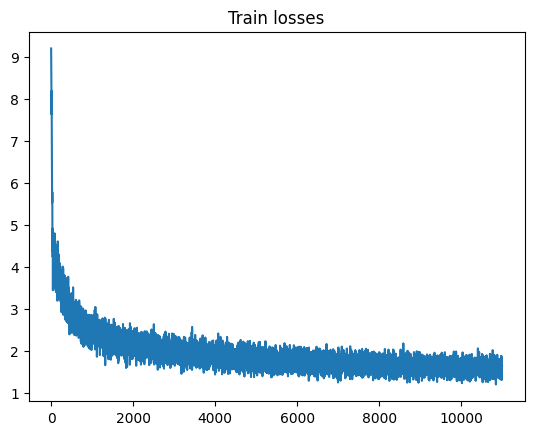

In [65]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.title("Train losses")
plt.show()

In [76]:
gen_info = generate_text(model,"mix flour with ",200,0.2)

generated text : 
 mix flour with  salt , pepper , and garlic cloves with salt and pepper to taste in a small saucepan over medium heat . add onion and cook , stirring , until softened , about 3 minutes . add wine and cook , stirring , until softened , about 5 minutes . add rice and cook , stirring , until softened , about 5 minutes . add water and simmer , covered , until tender , about 5 minutes . remove from heat and let stand , covered , 10 minutes . peel and seed peppers . cut off and discard core from each slice . cut peel and white pith from oranges . cut segments free from membranes and discard membranes . heat oil in a 12-inch heavy skillet over moderately high heat until hot but not smoking , then cook onions , stirring , until golden , about 3 minutes . add wine and cook , stirring , until softened , about 5 minutes . add tomatoes and simmer , covered , stirring occasionally , until vegetables are tender , about 1 hour . remove from heat and stir in remaining ingredients . <

In [79]:
params=model.parameters()

In [81]:
theparams=[param for param in params]

In [101]:
np.cumprod(np.arange(1,9))

array([    1,     2,     6,    24,   120,   720,  5040, 40320])